In [1]:
!mkdir chap10
%cd ./chap10

/content/chap10


In [2]:
!pip install transformers==4.5.0 fugashi==1.1.0 ipadic==1.0.0

     |████████████████████████████████| 2.1 MB 13.4 MB/s 
     |████████████████████████████████| 486 kB 47.6 MB/s 
     |████████████████████████████████| 13.4 MB 58.1 MB/s 
     |████████████████████████████████| 895 kB 56.7 MB/s 
     |████████████████████████████████| 3.3 MB 57.1 MB/s 
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=b988611906681aac70586f0e3cd2d55afdb0e3b8a84596f910dd86f714086dc2
  Stored in directory: /root/.cache/pip/wheels/33/8b/99/cf0d27191876637cd3639a560f93aa982d7855ce826c94348b
Successfully built ipadic


In [3]:
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

# BERTの日本語モデル
MODEL_NAME = 'cl-tohoku/bert-base-japanese-whole-word-masking'

In [4]:
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz 
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz 

--2022-01-17 10:00:18--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  1.84MB/s    in 5.6s    

2022-01-17 10:00:26 (1.50 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]



In [5]:
# カテゴリーのリスト
category_list = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]

# トークナイザとモデルのロード
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)
model = model.cuda()

# 各データの形式を整える
max_length = 256
sentence_vectors = [] # 文章ベクトルを追加していく。
labels = [] # ラベルを追加していく。
for label, category in enumerate(tqdm(category_list)):
    for file in glob.glob(f'./text/{category}/{category}*'):
        # 記事から文章を抜き出し、符号化を行う。
        lines = open(file).read().splitlines()
        text = '\n'.join(lines[3:])
        encoding = tokenizer(
            text, 
            max_length=max_length, 
            padding='max_length', 
            truncation=True, 
            return_tensors='pt'
        )
        encoding = { k: v.cuda() for k, v in encoding.items() } 
        attention_mask = encoding['attention_mask']

        # 文章ベクトルを計算
        # BERTの最終層の出力を平均を計算する。（ただし、[PAD]は除く。）
        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state 
            averaged_hidden_state = \
                (last_hidden_state*attention_mask.unsqueeze(-1)).sum(1) \
                / attention_mask.sum(1, keepdim=True) 

        # 文章ベクトルとラベルを追加
        sentence_vectors.append(averaged_hidden_state[0].cpu().numpy())
        labels.append(label)

# それぞれをnumpy.ndarrayにする。
sentence_vectors = np.vstack(sentence_vectors)
labels = np.array(labels)

Downloading:   0%|          | 0.00/258k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/479 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

100%|██████████| 9/9 [01:54<00:00, 12.70s/it]


In [6]:
# 二次元空間に圧縮、主成分分析、principal component analysis
sentence_vectors_pca = PCA(n_components=2).fit_transform(sentence_vectors) 
print(sentence_vectors_pca.shape)

(7367, 2)


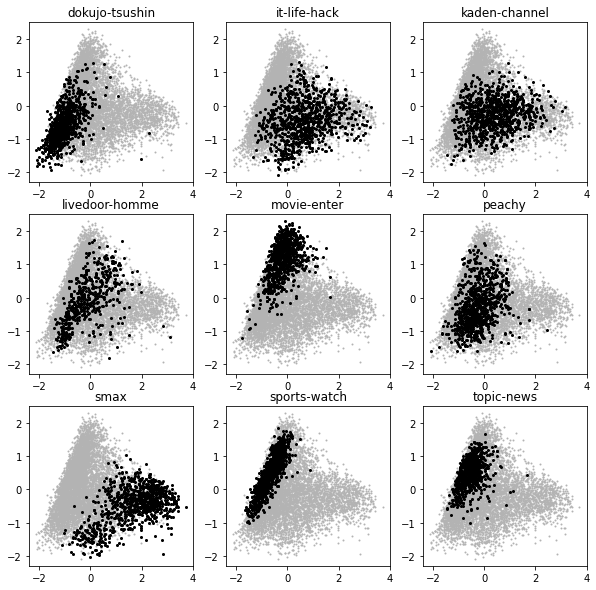

In [7]:
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_pca[:,0], 
        sentence_vectors_pca[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_pca[index,0], 
        sentence_vectors_pca[index,1], 
        'o', 
        markersize=2, 
        color='k'
    )
    plt.title(category_list[label])

In [8]:
sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


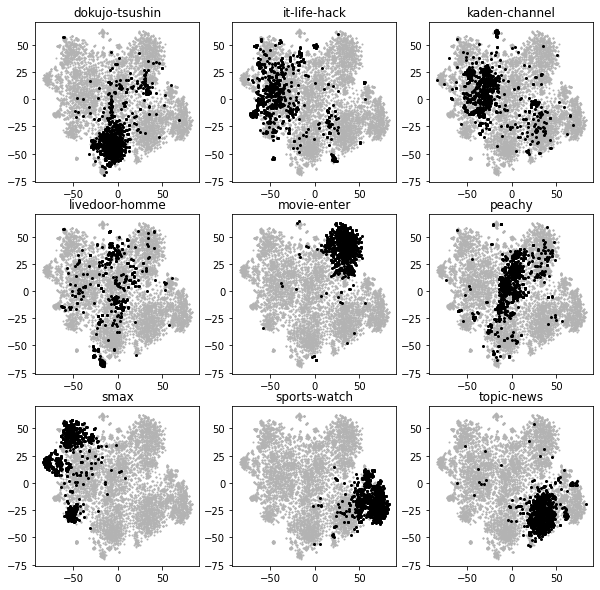

In [9]:
plt.figure(figsize=(10,10))
for label in range(9):
    plt.subplot(3,3,label+1)
    index = labels == label
    plt.plot(
        sentence_vectors_tsne[:,0],
        sentence_vectors_tsne[:,1], 
        'o', 
        markersize=1, 
        color=[0.7, 0.7, 0.7]
    )
    plt.plot(
        sentence_vectors_tsne[index,0],
        sentence_vectors_tsne[index,1], 
        'o',
        markersize=2,
        color='k'
    )
    plt.title(category_list[label])

In [10]:
# 先にノルムを1にしておく。
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True) 
sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算する。
# 類似度行列の(i,j)要素はi番目の記事とj番目の記事の類似度を表している。
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 入力と同じ記事が出力されることを避けるため、
# 類似度行列の対角要素の値を小さくしておく。
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る
similar_news = sim_matrix.argmax(axis=1) 

# 類似文章検索により選ばれた記事とカテゴリーが同一であった記事の割合を計算
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = ( input_news_categories == output_news_categories ).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83
